my first notebook

thank you DANIIL KARPOV https://www.kaggle.com/code/vanguarde/h-m-eda-first-look for giving me all the inspiration

## **<span style="color:#008000;font-size:490%"><center>EDA</center></span><span style="color:#008000;font-size:200%"><center>Exploratory Data Analysis. H&M</center></span>**

# Introduction

For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.


The dataset contains 4 csv files and one folder with several subfolders, each with a different number of images.

In this Exploratory Data Analysis Notebook we will look to the data, will analyze the content of each csv file, check for missing data, understand the data distribution, see what are the relations between data in various files.

We will also explore the image data, understand how images are indexed in the csv files, if there are articles in the dataset without images. We will also explore image additional information, like image width and height.

We also investigate a very simple baseline model and create an initial submission.

For baseline model I migth use weekly bestsellers. 

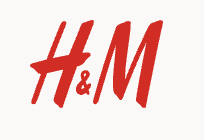

# Analysis preparation

We will include here the required packages for reading, parsing, filtering, processing, visualizing the data, both tabular and image.

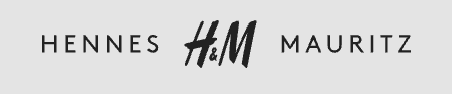


In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from PIL import Image
from plotnine import *

In [2]:
file_path = "../Dataset/"

In [3]:
articles = pd.read_csv(file_path + "articles.csv")
customers = pd.read_csv(file_path + "customers.csv")
transactions = pd.read_csv(file_path + "transactions_train.csv")

### first lets go through the articles that is selling on H&M

In [4]:
len(articles.columns)

25

So we have in total of 25 columns. What are they? what are their characters?

In [5]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

article_id : A unique identifier of every article.

product_code, prod_name : A unique identifier of every product and its name (not the same).

product_type, product_type_name : The group of product_code and its name

graphical_appearance_no, graphical_appearance_name : The group of graphics and its name

colour_group_code, colour_group_name : The group of color and its name

perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name : The added color info

department_no, department_name: : A unique identifier of every dep and its name

index_code, index_name: : A unique identifier of every index and its name

index_group_no, index_group_name: : A group of indeces and its name

section_no, section_name: : A unique identifier of every section and its name

garment_group_no, garment_group_name: : A unique identifier of every garment and its name

detail_desc: : Details

I notice that all of the data here is categorical / index for each feature. 

So Let's do some question and answer style to think about this data!

clean up the data for a little bit. I first want to get rid of colinearity on all columns.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)

In [7]:
articles.article_id = article_id_str_to_int(articles.article_id)

In [8]:
encoded_articles = articles.copy()

In [9]:
for col in encoded_articles.columns:
    if encoded_articles[col].dtype == 'object':
        encoded_articles[col] = Categorize().fit_transform(articles[[col]])[col]

for col in encoded_articles.columns:
    if encoded_articles[col].dtype == 'int64':
        encoded_articles[col] = encoded_articles[col].astype('int32')

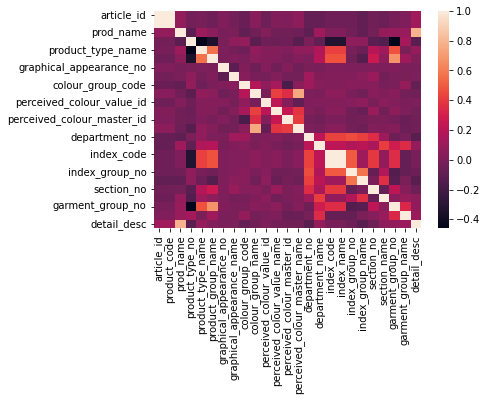

In [10]:
sns.heatmap(encoded_articles.corr());

In [11]:
encoded_articles = encoded_articles.drop(columns = ['product_code','prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name','detail_desc'])

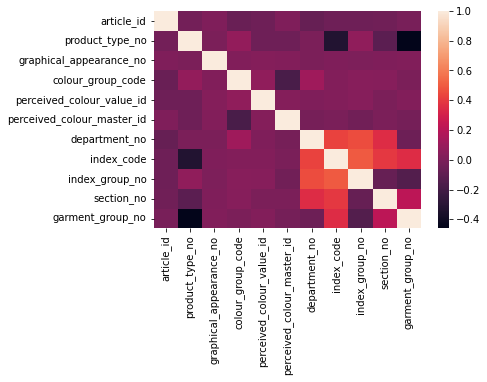

In [12]:
sns.heatmap(encoded_articles.corr());

First I want to take out columns that have high colinearity. 

By human check, taking out the high coliearity variables. That's all i will do for now

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

Lets peek into what are the things in articles.

In [14]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [15]:
product_count = pd.DataFrame(articles[['product_code']].value_counts().sort_values(ascending=False),columns = ['count'])
product_count = product_count.reset_index()
product_count

,product_code,count
0,783707,75
1,684021,70
2,699923,52
3,699755,49
4,685604,46
...,...,...
47219,548757,1
47220,548744,1
47221,548738,1
47222,548724,1


In [16]:
name_code = articles[['prod_name','product_code']].drop_duplicates(['product_code'])

In [17]:
product_distribution = product_count.merge(name_code, left_on='product_code',right_on='product_code')
product_distribution.describe()

,product_code,count
count,47224.000000,47224.000000
mean,715504.671396,2.234923
std,123905.601113,2.592072
min,108775.000000,1.000000
25%,627468.000000,1.000000
50%,717666.500000,1.000000
75%,812941.750000,2.000000
max,959461.000000,75.000000


Majority of product only has 1-2 variation. We may need to remove outliers that is 75 variation. 
We can set threshold that more than 10 different product's product we may take them out. 

or it may not be necessary.

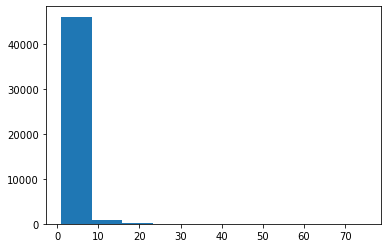

In [18]:
plt.hist(product_distribution['count'])
plt.show() 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f840d37b9a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f840d37bfa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f840d37b6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f840d38d520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f840d38d7f0>],
 'means': []}

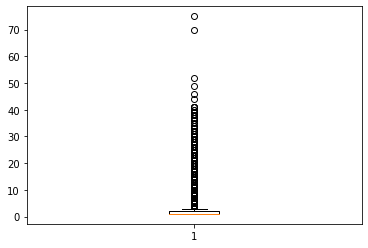

In [19]:
plt.boxplot(product_distribution['count'])

In [20]:
name_code.head(2)

,prod_name,product_code
0,Strap top,108775
3,OP T-shirt (Idro),110065




<font size="5">By looking at product code, we can see top one percent of product have multiple different variation. Like \#1 most count of product is actually kid clothing!
Whereas the 90% of the product is only average of 1-2 variation. </font>

<font size="5">From here we can note that the same product can have 1-2 variation variation. </font>

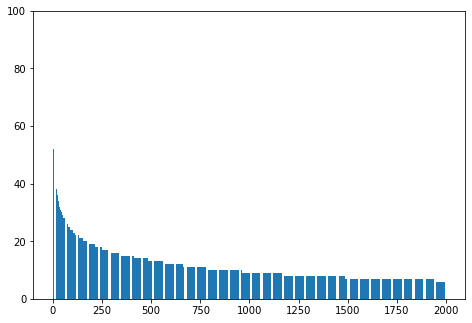

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_count.index[:2000],product_count['count'][:2000])
plt.ylim([0, 100])
plt.show()

In [22]:
product_name = articles[['product_code','prod_name']]

In [23]:
product_count.merge(product_name, how = "left", left_on="product_code",right_on="product_code").sort_values(by='count')

,product_code,count,prod_name
105541,959461,1,Lounge dress
89491,624309,1,SB Mason Trousers
89492,624310,1,BB Mason Trousers
89493,659011,1,LF Clematis Frill Dress
89494,761350,1,Dixie tee
...,...,...,...
52,783707,75,1pk Fun
53,783707,75,1pk Fun
55,783707,75,1pk fun sock
47,783707,75,1pk Fun


<font size="5">I notice the most repeated product is kid clothing!
</font>

<font size="5">
        prod_name can be really creative, and can definitely contribute later. For now, I may skip this variable. 
</font>


<font size="5">
Now I can ask a better question, So what product type do we have here?
</font>

In [24]:
product_type = articles[['product_code', 'product_type_no','product_type_name']]

In [25]:
product_type_name = articles[['product_type_no','product_type_name']]
product_type_name = product_type_name.drop_duplicates()

In [26]:
product_type_name

,product_type_no,product_type_name
0,253,Vest top
3,306,Bra
6,304,Underwear Tights
7,302,Socks
8,273,Leggings/Tights
...,...,...
102766,521,Dog wear
103628,510,Eyeglasses
103910,523,Wireless earphone case
104253,491,Stain remover spray


<font size="5">
we have 132 unique type in all our articles. Lets see how they are distributed!
</font>

In [27]:
product_type = pd.DataFrame(product_type.groupby(by=["product_type_no"])['product_type_name'].count().sort_values(ascending=False))
product_type = product_type.reset_index()
product_type.columns = ['product_type_no', 'product_type_count']

In [28]:
product_type

,product_type_no,product_type_count
0,272,11169
1,265,10362
2,252,9302
3,255,7904
4,254,4155
...,...,...
127,492,1
128,468,1
129,483,1
130,489,1


In [29]:
type_no_to_name = dict(zip(product_type_name['product_type_no'],product_type_name['product_type_name']))

In [30]:
product_type['product_type_name'] = product_type['product_type_no'].apply(lambda x : type_no_to_name[x]) 

In [31]:
product_type.describe()

,product_type_no,product_type_count
count,132.000000,132.000000
mean,277.371212,799.560606
std,168.340005,1834.372989
min,-1.000000,1.000000
25%,93.750000,7.000000
50%,272.500000,104.500000
75%,464.250000,685.750000
max,762.000000,11169.000000


<font size="5">
Product type have many types 
</font>

In [32]:
product_type

,product_type_no,product_type_count,product_type_name
0,272,11169,Trousers
1,265,10362,Dress
2,252,9302,Sweater
3,255,7904,T-shirt
4,254,4155,Top
...,...,...,...
127,492,1,Washing bag
128,468,1,Bumbag
129,483,1,Clothing mist
130,489,1,Sewing kit


In [33]:
product_type['product_type_count'].quantile(0.8)

1032.8000000000002

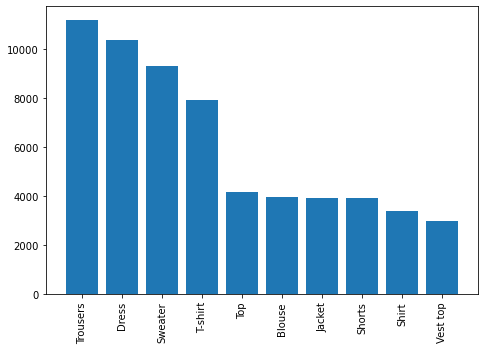

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_type['product_type_name'][:10],product_type['product_type_count'][:10])
plt.xticks(rotation='vertical')
plt.show()

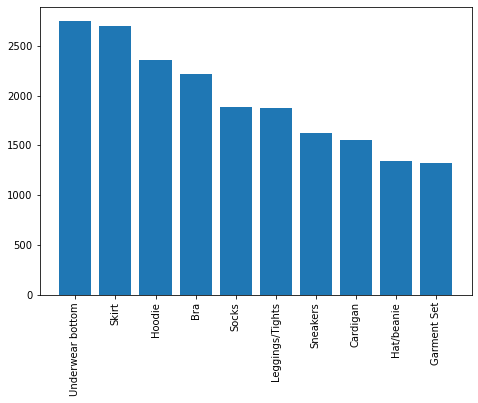

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_type['product_type_name'][10:20],product_type['product_type_count'][10:20])
plt.xticks(rotation='vertical')
plt.show()

<font size="5">
Seems like 
</font>

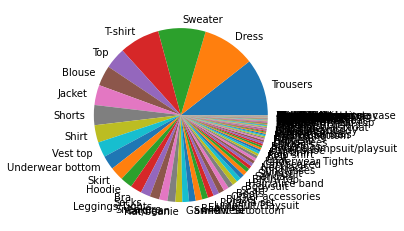

In [36]:
plt.pie(product_type['product_type_count'], labels = product_type['product_type_name'])
plt.show()

In [37]:
sum(product_type.head(5).product_type_count) / sum(product_type.product_type_count)

0.40639745314661463

In [38]:
# calculate the percentage of top 5 in all the articles

product_type[product_type['product_type_name'].isin(['Top','T-shirt','Sweater','Dress','Trousers'])]['product_type_count'].sum() / product_type['product_type_count'].sum()

0.40639745314661463


<font size="5">
Trouser Dress Sweater T-shirt Top Blouse is highly skewed Since they take up more than 40% of articles in H&M
</font>


<font size="4">
I was exploring what type of articles do we have. And I found that that top 5 most provided type,'Top','T-shirt','Sweater','Dress','Trousers' takes up 40% of the articles sound at H&M. That's crazy! I was expecting it will be more even distribution among all the product type. 
</font>

In [39]:
product_group = pd.DataFrame(articles[['article_id','product_group_name']].groupby('product_group_name')['article_id'].count().sort_values(ascending=False))
product_group = product_group.reset_index()
product_group.columns = ['product_group_name','count']
product_group

,product_group_name,count
0,Garment Upper body,42741
1,Garment Lower body,19812
2,Garment Full body,13292
3,Accessories,11158
4,Underwear,5490
5,Shoes,5283
6,Swimwear,3127
7,Socks & Tights,2442
8,Nightwear,1899
9,Unknown,121


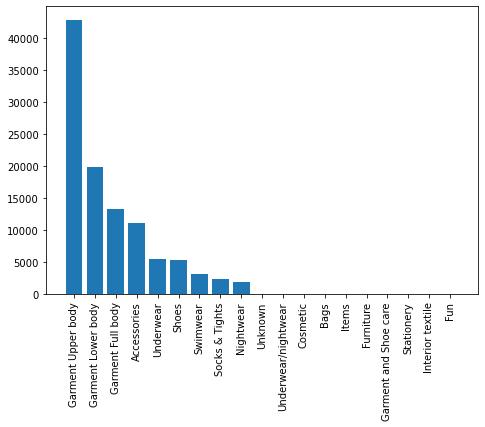

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_group['product_group_name'],product_group['count'])
plt.xticks(rotation='vertical')
plt.show()

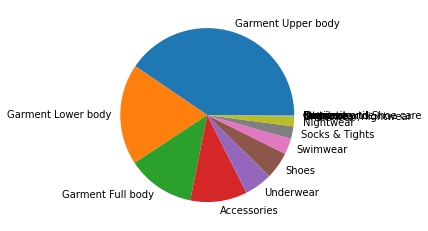

In [41]:
plt.pie(product_group['count'], labels = product_group['product_group_name'])
plt.show()


So far we have looked at data from 1 dimension. Now lets increase the dimension and explore more!

In [42]:
articles.groupby(['product_group_name','index_name'])['article_id'].count().sort_values()

product_group_name  index_name                    
Items               Menswear                              1
Bags                Ladies Accessories                    1
Unknown             Children Accessories, Swimwear        1
Garment Upper body  Lingeries/Tights                      2
Unknown             Children Sizes 134-170                2
                                                      ...  
Garment Full body   Ladieswear                         5599
Garment Lower body  Ladieswear                         5701
Garment Upper body  Menswear                           6855
                    Divided                            6999
                    Ladieswear                        14095
Name: article_id, Length: 99, dtype: int64

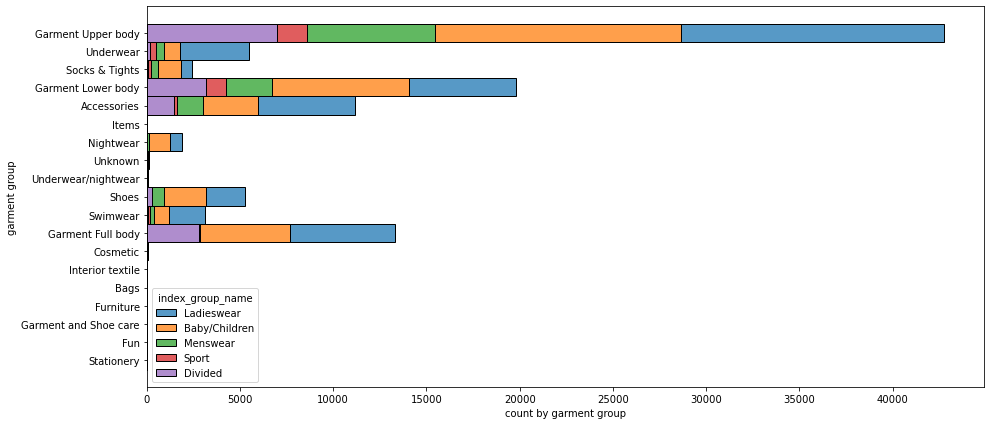

In [43]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='product_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

### I definitley notice *lady and children* is dominating almost all the garment group. 

In [44]:
articles.groupby(['index_group_name','index_name']).count()['article_id']

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

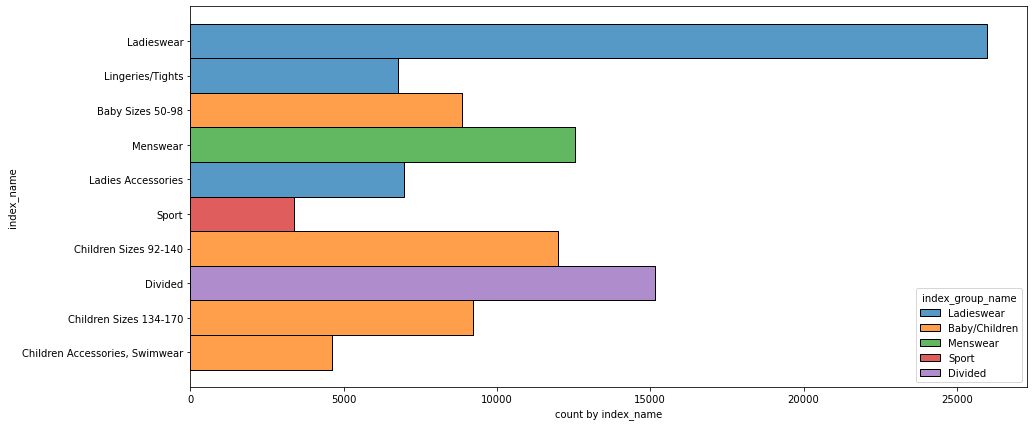

In [45]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by index_name')
ax.set_ylabel('index_name')
plt.show()

In [46]:
pd.options.display.max_rows = None

articles.groupby(['product_group_name', 'product_type_name','index_group_name']).count()['article_id']
#.get("Accessories").sort_values()

product_group_name     product_type_name         index_group_name
Accessories            Accessories set           Baby/Children          7
                       Alice band                Baby/Children          1
                                                 Ladieswear             5
                       Baby Bib                  Baby/Children          3
                       Bag                       Baby/Children        135
                                                 Divided              351
                                                 Ladieswear           621
                                                 Menswear             130
                                                 Sport                 43
                       Beanie                    Baby/Children         32
                                                 Divided                6
                                                 Ladieswear             1
                                              

Since now we have some understanding of Articles, aka most of the stuff are for female and children. 

we can give a look at Customers and check if there is any interesting finding!

In [47]:
# missing data percentage
customers.isna().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [48]:
# since its hard to know what age just base on this, we may omit and try guess their age base on what they buy ?

age_na_cus = customers.age.isna()

# kept the one that has age 

customers_age = customers[age_na_cus.apply(lambda x : not x)]

lets check out the distribution of age.

In [49]:
customers_age = customers_age.sort_values(by='age',ascending=False)

In [51]:
customers_age.head(3)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
1278960,eeaeb36eecef27871a0fe587858906e5f28d43872f6a4a...,1.0,1.0,ACTIVE,Regularly,99.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
307448,39719241efb3559eca60886d58f0fe01cbf8d5efea0e25...,1.0,1.0,ACTIVE,Regularly,99.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1246886,e8b2a7bf44f42e808d58299c53e6e1ad47178d7d457f82...,NaN,NaN,ACTIVE,NONE,99.0,cc02109b1630ec7235ba6f5d61f07c1473b0b9d637ae7c...


In [52]:
customers_age.shape

(1356119, 7)

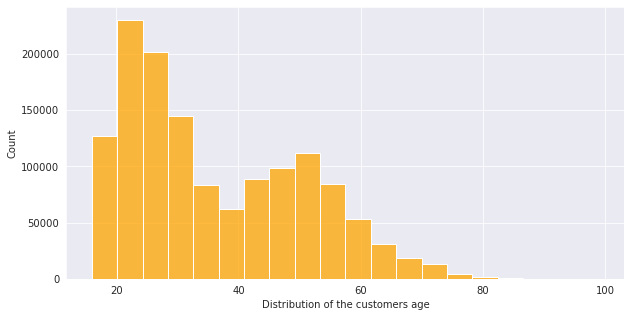

In [53]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_age, x='age', bins=20, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

Not much for customer data besides their age, news, and club member status

now i want to find out maybe how much the same customer spend by monthly in 2019/9/22 - 2020/9/22. 

In [54]:
transactions = transactions.sort_values(['customer_id'])

In [ ]:
transactions.t_dat

In [ ]:
transactions.describe()

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=transactions, x='price', bins=100, color='orange')
ax.set_xlabel('Distribution of the customer spending')
plt.xlim([0,0.2])
plt.show()

In [ ]:
transactions.groupby('customer_id')

In [ ]:
last_year_tran = transactions[transactions['t_dat'] >= '2019-09-22']

In [ ]:
last_year_tran.t_dat = pd.to_datetime(last_year_tran.t_dat)

In [ ]:
last_year_tran['month'] = last_year_tran.t_dat.apply(lambda x : x.month)

# import cudf
# train = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
# train['customer_id'] = train['customer_id'].str[-16:].str.hex_to_int().astype('int64')
# train['article_id'] = train.article_id.astype('int32')
# train.t_dat = cudf.to_datetime(train.t_dat)
# train = train[['t_dat','customer_id','article_id']]
# train.to_parquet('train.pqt',index=False)
# print( train.shape )
# train.head()

How many unique customer made purchase in 2022?

In [ ]:
last_year_tran['customer_id'].nunique()

**<span style="color:#008000;"> Let's see the general summary about the transaction</span>**

So I want to see what is the totoal number of item from each customer for last year of transaction. 

In [ ]:
cus_bought_count = pd.DataFrame(last_year_tran.groupby('customer_id')['article_id'].count().sort_values(ascending=False))

In [ ]:
last_year_tran

In [ ]:
cus_bought_count = cus_bought_count.reset_index()
cus_bought_count.columns = ['customer_id','article_count']

In [ ]:
cus_bought_count.describe()

Since I noticed huge discrepency between people who are top 10% of customer and rest of 90%

I may want to consider top 10 to be loyal customer as average of them purchase at least 2-3 item every month.

while the rest of 90% make occasional purchases. 

In [ ]:
cus_bought_count[cus_bought_count['article_count'] >= 36]['article_count'].describe()

In [ ]:
cus_bought_count[cus_bought_count['article_count'] < 36]['article_count'].describe()

Now I have a business related question, top 10% customer is responsible for how much % of revenue in last year?


In [ ]:
cus_spent = pd.DataFrame(last_year_tran.groupby('customer_id')['price'].sum().sort_values(ascending=False)).reset_index()

In [ ]:
cus_spent.head(2)

In [ ]:
top_10 = cus_bought_count[cus_bought_count['article_count'] >= 36]

In [ ]:
top_10_count_spent = top_10.merge(cus_spent, how='left', left_on='customer_id',right_on='customer_id')

In [ ]:
top_10_count_spent.sample(3)

In [ ]:
top_10_count_spent.price.sum() / last_year_tran.price.sum()

After some digging, I find out top 10% of the customer is responsible for 45% of sale in 2022.

If I was the CEO, I will be really sure those 10% of cusotmer get best possible experience to maintain relationship with them. 

In [ ]:
plt.boxplot(cus_bought_count['article_count'])

Now I want to know what items have the customer bought throughout the entire year. Can be guess about their spending behavior and potentially age and gender?

In [ ]:
#I will start with top 10% customers. Aka loyal customers.
top_10.head(1)

I am going to explore what has our \#1 customer has bought for the last year, as this customer bought 1020 items in the last year. 

In [ ]:
number_1 = last_year_tran[last_year_tran['customer_id'] == top_10.head(1)['customer_id'].values[0]]

In [ ]:
articles.head(3)


In [ ]:
stuff_number1_bought = number_1.merge(articles, how = 'left', left_on = 'article_id', right_on = 'article_id')

In [ ]:
articles['product_group_name'].head(2)

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=stuff_number1_bought, y='product_group_name', color='orange', hue='index_name', multiple="stack")
# ax.set_xlabel('count by garment group')
# ax.set_ylabel('garment group')
plt.show()

From my understanding, Divided is also mainly female clothing. 

In [ ]:
customers.head(2)

In [ ]:
stuff_number1_bought.head(3)

In [ ]:
customers[customers['customer_id'] == top_10.head(1)['customer_id'].values[0]]